# BasicOptionPricing Workbook
--- Nov-21-2019, Alan, Shaolun.du@gmail.com

This is a detailed documentation on Option Pricing, mainly in Rates and Currency area. In the following, I will go over three different types of options and detailed on how to price them with QuantLib: 

- FX Option: Basic option on FX forward.
- Caps/Floors: A bundle of caplets or floorlets based on rate index.
- Swaption: Basic option on interest rate swap(I will only talk about swaption on signle currency vanilla swap).

*** NOTE: As we were doing previously, I will continue using USD curve as an example going forward, and I will use USD/EUR for FX option as an example.***

## 0 - Brief introducation on QuantLib Option pricing

Price of any derivative, be it a plain-vanilla option or a complex structured product, depends on the following inputs:
1. Price of the underlying securities as on date of pricing and their feeds
2. Term structure of interest rates, volatility, inflation and default probabilities
3. Cash flows (including coupons and dividends) from the instrument
4. Stochastic process for the underlying
5. Pricing engine (the numerical method used for pricing)

## 1 - FX Option Pricing

To start, please import the library:

In [11]:
import QuantLib as ql
import numpy as np
import math
from scipy.integrate import simps, cumtrapz, romb
import matplotlib.pyplot as plt
%matplotlib inline

Setup option paramaters below:
1. We are looking into USDCAD currency FX option, starting 2017-Mar-23 maturity 2017-Apr-24
2. Spot rate = 1.3347, Strike rate = 1.3338, vol = 6.55%, CAD rf = 0/5% and USD rf = 0.75%

In [48]:
# option data
calculation_date = ql.Date(23, 3, 2017)
maturity_date = ql.Date(24, 4, 2017)
option_type = ql.Option.Put
spot_price = 1/1.3347
strike_price = 1/1.3338
volatility = 0.0655 # the historical vols for a year
f_rate =  0.005 # the target currency risk free rate
d_rate = 0.0075 # domestic currency risk free rate
day_count = ql.Business252()
calendar = ql.UnitedStates()
ql.Settings.instance().evaluationDate = calculation_date

The Black-Scholes-Merto process is constructed below:

***NOTE***: I am using a flat risk free curve here, to get a more accurate implementation we can use bootstrapped yield curve from "NoteBook:Bootstrapping".

In [44]:
# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)
# BK engine
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_f = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, f_rate, day_count)
)
flat_d = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, d_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess( spot_handle, 
                                            flat_f, 
                                            flat_d, 
                                            flat_vol_ts )

Compute option value:

In [47]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print("The theoretical price is {}(CAD),{}(USD)".format(bs_price,bs_price/spot_price))

The theoretical price is 0.0056946859070836735(CAD),0.0076006972801845795(USD)


## 2 - Cap/Floor Option Pricing

In this section, I will talk about how to use QuantLib price caps and floors with our USD example. To value a cal or floor, we need the following objects setup:
1. Interest rate term structure for discounting, (Use previous USD curve)
2. Volatility term structure for Black formula v-lookup. (We will use flat-vol)
3. Construction of the cap.
4. Pricing engine to value caps using the Black formula.

Now Let's start:

## 2 - a Cap/Floor Option Pricing: Yield curve term structure

In [49]:
# Helper function for curve building please refer to previous post
# Pull out a yield curve for pricing
# Details please refer to previous workbook, we will use USD LIBOR curve here.
Con_dict = {
# All details listed here is directly from the market instruments
# If changed to another sets of market instruments please update details here!
    "Cash":{ "DayCount":ql.Actual360(),
             "EOM":False, # Check if end of month please change correspondingly
             "BsDay":ql.ModifiedFollowing,
             "Calendar":ql.UnitedStates(),
             "SettlementDays": 2, # Settlement shift after fixing
           },
    "Future":{ "DayCount":ql.Actual360(),
               "EOM":False, # Check if end of month please change correspondingly
               "BsDay":ql.ModifiedFollowing,
               "ConVes_Adj":ql.QuoteHandle(ql.SimpleQuote(0.0)),# For convexity adjustment
               "Calendar":ql.UnitedStates(),
               "SettlementDays": 2, # Settlement shift after fixing
               "LengthInMonths": 3,
             },
    "Swap":{  "Index":ql.USDLibor(ql.Period(3,ql.Months)), # Floating Leg index rate
              "FloatingLegTenor":ql.Period(3,ql.Months),
              "FloatingLegFrequency":ql.Quarterly,
              "FloatingLegAdjustment":ql.ModifiedFollowing,
              "FloatingLegDayCounter":ql.Actual360(),
              "FixedLegFrequency":ql.Semiannual,
              "FixedLegTenor":ql.Period(6,ql.Months),
              "FixedLegAdjustment":ql.ModifiedFollowing,
              "FixedLegDayCounter":ql.Thirty360(),
              "SettlementDays": 2, # Settlement shift after fixing
              "Calendar":ql.UnitedStates(),
            },
}
Mkt_dict = {
    "SDate": ql.Date(18,11,2019), # Curve starting date
    "Cash":{ (1,ql.Months): 0.018325,
             (3,ql.Months): 0.019026,
             (6,ql.Months): 0.019185,
           },
    "Future":{ # IMM dates can be automated using above functions
               # For clearly here I keep it as inputs date values
               ql.Date(18,12,2019): 98.1125,
               ql.Date(18,3,2020): 98.325,
               ql.Date(17,6,2020): 98.415,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.49,
               ql.Date(16,9,2020): 98.55,
             },
    "Swap":{  (2,ql.Years): 0.01604,
              (3,ql.Years): 0.0157,
              (4,ql.Years): 0.01567,
              (5,ql.Years): 0.015785,
              (6,ql.Years): 0.01597,
              (7,ql.Years): 0.0162,
              (8,ql.Years): 0.016475,
              (9,ql.Years): 0.01677,
              (10,ql.Years): 0.01705,
              (11,ql.Years): 0.017315,
              (12,ql.Years): 0.01756,
              (15,ql.Years): 0.01811,
              (20,ql.Years): 0.01869,
              (25,ql.Years): 0.0189,
              (30,ql.Years): 0.018932,
              (40,ql.Years): 0.01873,
            },
}
def Bootstrapping( Market, Convention ):
    sDate = Market["SDate"]
    ql.Settings.instance().evaluationDate = sDate
    # Convert market quotes into QuantLib "Quote objects"
    deposits = Market["Cash"]
    futures  = Market["Future"]
    swaps    = Market["Swap"]
    deposits_con  = Convention["Cash"]
    futuresc_con  = Convention["Future"]
    swaps_con     = Convention["Swap"]
    for n,unit in deposits.keys():
        deposits[(n,unit)] = ql.SimpleQuote(deposits[(n,unit)])
    for d in futures.keys():
        futures[d] = ql.SimpleQuote(futures[d])
    for n,unit in swaps.keys():
        swaps[(n,unit)] = ql.SimpleQuote(swaps[(n,unit)])
    # Build up helpers for curve building
    depositHelpers = [ ql.DepositRateHelper( ql.QuoteHandle(deposits[(n,unit)]),
                                             ql.Period(n,unit), deposits_con["SettlementDays"],
                                             deposits_con["Calendar"], deposits_con["BsDay"],
                                             deposits_con["EOM"], deposits_con["DayCount"])
                       for n, unit in deposits.keys() ]
    futuresHelpers = [ ql.FuturesRateHelper( ql.QuoteHandle(futures[d]),
                                             d, futuresc_con["LengthInMonths"],
                                             futuresc_con["Calendar"], futuresc_con["BsDay"],
                                             futuresc_con["EOM"], futuresc_con["DayCount"],
                                             futuresc_con["ConVes_Adj"])
                       for d in futures.keys() ]
    swapHelpers = [ ql.SwapRateHelper( ql.QuoteHandle(swaps[(n,unit)]),
                                       ql.Period(n,unit), swaps_con["Calendar"],
                                       swaps_con["FixedLegFrequency"], swaps_con["FixedLegAdjustment"],
                                       swaps_con["FixedLegDayCounter"], swaps_con["Index"])
                    for n, unit in swaps.keys() ]
    # term-structure construction
    helpers = depositHelpers + futuresHelpers + swapHelpers # Helpers combined
    yts = ql.PiecewiseFlatForward( sDate, helpers, ql.Actual360()) # Forward curve defination
    yts.enableExtrapolation()
    return yts

# Generate USE LIBOR yield curve with TermStructure object
yts = Bootstrapping(Mkt_dict, Con_dict)
hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build discounting curve into a term structure
f_hyts = ql.RelinkableYieldTermStructureHandle(yts) # Build forward curve term structure

## 2 - b Cap/Floor Option Pricing: Volatility term structure

To get vol termstructure we usually have to use a 2D surface but in this example I will strip the market quoted capfloor volatilities to infer the volatility of each and every caplet. Also, QuantLib provides excellent tools in order to do that.

In [61]:
# Market vol data for relevent strikes
strikes = [0.01,0.015, 0.02]
# Tenor 1,2,3,4,5,7,10,12
expiries = [ ql.Period(1, ql.Years), ql.Period(2, ql.Years),
             ql.Period(3, ql.Years), ql.Period(4, ql.Years),
             ql.Period(5, ql.Years), ql.Period(7, ql.Years),
             ql.Period(10, ql.Years), ql.Period(12, ql.Years),]
vols = ql.Matrix(len(expiries), len(strikes))
data = [[43.06,43.46,48.98,48.64,49.19,48.27,47.87,47.354],
        [27.53,34.72,38.45,41.01,41.2,41.22,40.57,40.062],
        [24.44,30.36,32.02,35.93,35.85,36.48,35.51,35.018]
       ]
for i in range(vols.rows()):
    for j in range(vols.columns()):
        vols[i][j] = data[j][i]/100.0
        
calendar = ql.UnitedStates()
bdc = ql.ModifiedFollowing
daycount = ql.Actual365Fixed()
settlement_days = 2
capfloor_vol = ql.CapFloorTermVolSurface(settlement_days, calendar, bdc, expiries, strikes, vols, daycount)
# Build up option surface
optionlet_surf = ql.OptionletStripper1(capfloor_vol, ibor_index)
ovs_handle     = ql.OptionletVolatilityStructureHandle(
                    ql.StrippedOptionletAdapter(optionlet_surf))

Let's take a look at those surfaces. The way to construct(strip) the optionlet volatility is simple, we use the following formula:
$$VOL^{2}_{t}*t = VOL^{2}_{t-1,t} + VOL^{2}_{t-1}*(t-1)$$

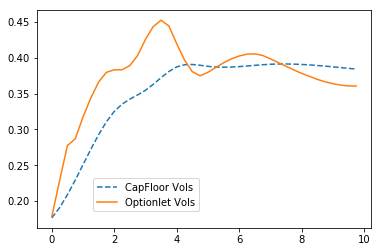

In [63]:
tenors = np.arange(0,10,0.25)
strike = 0.017
capfloor_vols = [capfloor_vol.volatility(t, strike) for t in tenors]
opionlet_vols = [ovs_handle.volatility(t, strike) for t in tenors]

plt.plot(tenors, capfloor_vols, "--", label="CapFloor Vols")
plt.plot(tenors, opionlet_vols,"-", label="Optionlet Vols")
plt.legend(bbox_to_anchor=(0.5, 0.25))

## 2 - c&d Cap/Floor Option Pricing: Cap/Floor object build and pricing engine setup

In [106]:
# This is an example with Cap pricing 
# The same thing happends with Floor pricing
start_date = ql.Date(1, 1, 2020)
end_date = ql.Date(1, 1 , 2023)
period = ql.Period(3, ql.Months)
calendar = ql.UnitedStates()
buss_convention = ql.ModifiedFollowing
rule = ql.DateGeneration.Forward
end_of_month = False
schedule = ql.Schedule(start_date, end_date, period,
                       calendar, buss_convention, buss_convention, 
                       rule, end_of_month)

ibor_index = ql.USDLibor(ql.Period(3, ql.Months), hyts)
ibor_leg = ql.IborLeg([100000000], schedule, ibor_index)
strike = 0.015
cap = ql.Cap(ibor_leg, [strike])

engine = ql.BlackCapFloorEngine(hyts, ovs_handle)

cap.setPricingEngine(engine)
print(cap.NPV())

852876.6718454376


## 3 - Swaption Pricing

In this section, I will walk you through swaption pricing in QuantLib with actual USD term structure we used before. In general, a swaption is an option allows holder to have the right go into a swap with pre-determined details. The pricing here we will use is the basic Black-Shores derived formula, called BLK76.

Actually, we will do the followings:
1. Model a USD yield curve term structure. (Already done, use the previous term structure)
2. Model a underlying swap deal for swaption. (Borrow from NOTE:Bootstrapping examlpe USD swap.)
3. Inputs USD swaption vol cube (3D volatility surface).
4. Setp option object and pricing engine.

## 3 - a Swaption Pricing: Yield curve term structure & Swap model

***NOTE***: For swap deal details and how to model, please refer to my previous post:NOTEBOOK Bootstrapping

In [145]:
# Swap object defined as a dictionary with float leg and fixed leg
# Inorder to advance date in Quantlib we have to use a calender object
t_calendar = ql.UnitedStates()
settle_date = t_calendar.advance(Mkt_dict["SDate"], 2, ql.Years)
maturity_date = t_calendar.advance(settle_date, 5, ql.Years)
V_Swap_Dict = {
    "Type":ql.VanillaSwap.Receiver,
    "Notional":100000000,
    "Fixed_Leg":{
        "fixedSchedule":ql.Schedule( settle_date, 
                                     maturity_date, 
                                     ql.Period(6, ql.Months), ql.UnitedStates(),
                                     ql.ModifiedFollowing, ql.ModifiedFollowing,
                                     ql.DateGeneration.Forward, False),
        "fixedRate":0.02,
        "fixedDayCount":ql.Thirty360(),
    },
    "Float_Leg":{
        "floatSchedule": ql.Schedule( settle_date, 
                                      maturity_date, 
                                      ql.Period(3, ql.Months), ql.UnitedStates(),
                                      ql.ModifiedFollowing, ql.ModifiedFollowing,
                                      ql.DateGeneration.Forward, False),
        "index":ql.USDLibor(ql.Period(3,ql.Months),f_hyts),
        "spread":0,
        "floatingDayCount":ql.Actual360(),
    },
}
# vanillaSwap model
Swap = ql.VanillaSwap(   V_Swap_Dict["Type"], 
                         V_Swap_Dict["Notional"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedSchedule"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedRate"], 
                         V_Swap_Dict["Fixed_Leg"]["fixedDayCount"], 
                         V_Swap_Dict["Float_Leg"]["floatSchedule"],
                         V_Swap_Dict["Float_Leg"]["index"],
                         V_Swap_Dict["Float_Leg"]["spread"], 
                         V_Swap_Dict["Float_Leg"]["floatingDayCount"] )

## 3 - b Swaption Pricing: Vol-cube structure model

Inorder to price the swaption, the volatility surface will become a volatility cube (3D) with dimensions: Start, Tenor, Strike and Volatility. 

In [146]:
# Market vol data for relevent strikes
# Note here, the vol cube is flatterning into a 2D matrix
# inputs should also include ATM vols and different strike vols
###--- ATM inputs---###
ATM_optionTenors = [ql.Period(1, ql.Years), ql.Period(2, ql.Years), ql.Period(5, ql.Years)]

ATM_swapTenors   = [ql.Period(1, ql.Years), ql.Period(2, ql.Years), ql.Period(5, ql.Years)]

ATM_vols = [
    [0.431,0.4717,0.4502],
    [0.4625,0.4525,0.4363],
    [0.426,0.4109,0.3843],
]
atmVol = ql.SwaptionVolatilityStructureHandle(
            ql.SwaptionVolatilityMatrix(
                t_calendar,
                ql.Following,
                ATM_optionTenors,
                ATM_swapTenors,
                ql.Matrix(ATM_vols),
                ql.Actual360(),
            ))
###--- Different Strike inputs---###
optionTenors  = [ql.Period(1, ql.Years), ql.Period(2, ql.Years), ql.Period(5, ql.Years)]

swapTenors    = [ql.Period(2, ql.Years), ql.Period(5, ql.Years), ql.Period(10, ql.Years)]

strikeSpreads = [-0.01, 0.0, 0.01 ] # Only consider 1%-3% strikes, change when needed

nRows = len(optionTenors) * len(swapTenors)
nCols = len(strikeSpreads)
# Market vol data 
volSpreadsMatrix = [
            [0.4417, 0.0, -0.1147],
            [0.3652, 0.0, -0.0848],
            [0.2896, 0.0, -0.063],
            [0.3643, 0.0, -0.1045],
            [0.3023, 0.0, -0.0884],
            [0.2268, 0.0, -0.0753],
            [0.251, 0.0, -0.0818],
            [0.2001, 0.0, -0.0744],
            [0.1653, 0.0, -0.0685],
        ]
# Build vol termstructure
volSpreads = []
for i in range(nRows):
    volSpreadsRow = []
    for j in range(nCols):
        volSpreadsRow.append(ql.QuoteHandle(ql.SimpleQuote(volSpreadsMatrix[i][j])))
    volSpreads.append(volSpreadsRow)

# Setup swap index base
# The swap index base for USD swap should be "UsdLiborSwapIsdaFixAm" or "UsdLiborSwapIsdaFixPm"
# However, currently Nov-21-2019 this class is not supported in PYTHON.
# please wait for furthere implementation and update correspondingly.
swapIndexBase = ql.EuriborSwapIsdaFixA(ql.Period(10, ql.Years), f_hyts)
shortSwapIndexBase = ql.EuriborSwapIsdaFixA(ql.Period(2, ql.Years), f_hyts)

vegaWeightedSmileFit = False
VolCube = ql.SwaptionVolatilityStructureHandle(
            ql.SwaptionVolCube2(
                atmVol,
                optionTenors,
                swapTenors,
                strikeSpreads,
                volSpreads,
                swapIndexBase,
                shortSwapIndexBase,
                vegaWeightedSmileFit,
            )
        )

## 3 - c Swaption Pricing: Setup option object and pricing engine

In [147]:
# QuantLib Swaption handler
# BBG answer Long Payer 2% 0.9% and Long Reciver 3.0% 
effective = calendar.advance(Mkt_dict["SDate"], 2, ql.Years) # Forward effective date
swaption = ql.Swaption(Swap, ql.EuropeanExercise(effective), ql.Settlement.Cash)
# Black Swaption Engine
engine = ql.BlackSwaptionEngine(hyts, VolCube)
swaption.setPricingEngine(engine)
NPV_Swaption = swaption.NPV()
print("NPV of swaption={:.0f}, In terms of notional={:.1f}%".format(NPV_Swaption,100*NPV_Swaption/V_Swap_Dict["Notional"]))

NPV of swaption=2886487, In terms of notional=2.9%


## Summary
In this section I list out three different basic options pricing method with QuantLib Pyhton. However, as you noticed, current version of python QuantLib still needs work. When we are pricing FX option we treat it as an vanilla stock option with Dividend Rate replaced by foreign risk free rate. The more accurate way to do this is using the FX curve instead of assuming it is flat. We also priced Cap/Floor options with the actual USD term structure. And in the end we are pricing Swaption with actual USD term structure.
<font color='blue'>
1. This notebook is totally based on the previous one wiht bootstrapping and swap pricing. Any problems related to that please refer to previous workbook.
2. Swaption pricing missing an important class in PYTHON to setup a correct swap base index.
3. Considering the effort to actually input Swaption Cube in the next section, I will talk about how to use shrot rate model to price swaption.